# Library loading

In [1]:
%matplotlib inline

import pandas as pd # manipulate dataframes
import matplotlib
import matplotlib.pyplot as plt # plotting
import numpy as np
np.random.seed = 167 # fix random seed for reproducibility
import time, h5py, imelt, torch

from sklearn.metrics import mean_squared_error

from tqdm import tqdm 

# importing shutil module  
import shutil 

# First we check if CUDA is available
print("CUDA AVAILABLE? ",torch.cuda.is_available())

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
      
device = get_default_device()
print(device)

CUDA AVAILABLE?  True
cuda


# Loading data

In [2]:
# custom data loader, automatically sent to device
ds = imelt.data_loader("./data/NKAS_viscosity_reference.hdf5",
                         "./data/NKAS_Raman.hdf5",
                         "./data/NKAS_density.hdf5",
                         "./data/NKAS_optical.hdf5",
                         device)

ds.print_data()

################################
#### Dataset specifications ####
################################

Number of unique compositions (viscosity): 173
Number of unique compositions in training (viscosity): 113
Dataset separations are 0.65 in train, 0.14 in valid, 0.21 in test

Number of unique compositions (entropy): 44
Number of unique compositions in training (entropy): 30
Dataset separations are 0.68 in train, 0.16 in valid, 0.16 in test

Number of unique compositions (refractive index): 243
Number of unique compositions in training (refractive index): 167
Dataset separations are 0.69 in train, 0.16 in valid, 0.16 in test

Number of unique compositions (density): 205
Number of unique compositions in training (density): 139
Dataset separations are 0.68 in train, 0.16 in valid, 0.16 in test

Number of unique compositions (Raman): 58
Number of unique compositions in training (Raman): 48
Dataset separations are 0.83 in train, 0.17 in valid

This is for checking the consistency of the datase

# Training 1 model 

Selected architecture: 4 layers, 200 neurons per layer, very low dropout

Parameters were tuned after the random search, & learning rate by Bayesian Optimization & patience by hand.

In [3]:
nb_layers = 4
nb_neurons = 200
p_drop = 0.01

name = "./model/candidates/l"+str(nb_layers)+"_n"+str(nb_neurons)+"_p"+str(p_drop)+"_test"+".pth"

# declaring model
neuralmodel = imelt.model(4,nb_neurons,nb_layers,ds.nb_channels_raman,p_drop=p_drop) 

# criterion for match
criterion = torch.nn.MSELoss(reduction='mean')
criterion.to(device) # sending criterion on device

# we initialize the output bias and send the neural net on device
neuralmodel.output_bias_init()
neuralmodel = neuralmodel.float()
neuralmodel.to(device)


model(
  (activation_function): ReLU()
  (dropout): Dropout(p=0.01, inplace=False)
  (linears): ModuleList(
    (0): Linear(in_features=4, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=200, bias=True)
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Linear(in_features=200, out_features=200, bias=True)
  )
  (out_thermo): Linear(in_features=200, out_features=17, bias=True)
  (out_raman): Linear(in_features=200, out_features=850, bias=True)
)

In [4]:
#
# TRAINING
#
optimizer = torch.optim.Adam(neuralmodel.parameters(), lr = 0.0006) # optimizer
neuralmodel, record_train_loss, record_valid_loss = imelt.training(neuralmodel,ds,
                                                                     criterion,optimizer,save_switch=True,save_name=name,
                                                                     train_patience=400,min_delta=0.05,
                                                                     verbose=True)

Full training.

Epoch 0 => train loss: 195.1467742919922; valid loss: 143.09413146972656
Epoch 200 => train loss: 5.904855251312256; valid loss: 10.56926441192627
Epoch 400 => train loss: 3.0956780910491943; valid loss: 4.933417320251465
Epoch 600 => train loss: 2.0335700511932373; valid loss: 3.4598968029022217
Epoch 800 => train loss: 1.6537256240844727; valid loss: 2.89522647857666
Epoch 1000 => train loss: 1.4856466054916382; valid loss: 2.758596897125244
Epoch 1200 => train loss: 1.2512149810791016; valid loss: 2.335705041885376
Epoch 1400 => train loss: 1.146148681640625; valid loss: 2.6345224380493164
Epoch 1600 => train loss: 1.1321202516555786; valid loss: 2.3829894065856934
Running time in seconds: 117.333811044693
Scaled valid loss values are 0.89, 0.19, 0.53, 0.70, 0.40, 0.39 for Tg, Raman, density, entropy, ri, viscosity (AG)


# Observing how losses decline

./model/candidates/l4_n200_p0.01_test.pth


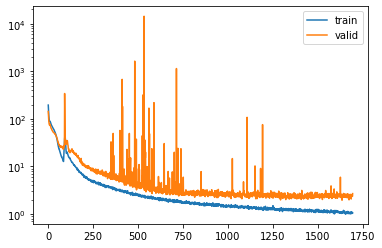

In [5]:
print(name)
plt.figure()
plt.plot(record_train_loss,label="train")
plt.plot(record_valid_loss,label="valid")
plt.legend()
plt.yscale("log")

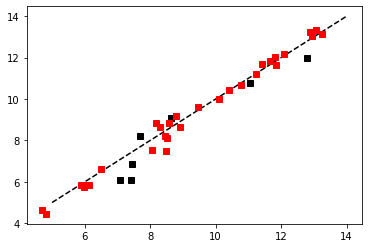

In [6]:
plt.plot([5,14],[5,14],'k--')
plt.plot(neuralmodel.sctg(ds.x_entro_valid).cpu().detach().numpy(),ds.y_entro_valid.cpu().detach().numpy(),'ks')
plt.plot(neuralmodel.sctg(ds.x_entro_train).cpu().detach().numpy(),ds.y_entro_train.cpu().detach().numpy(),'rs')

In [7]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(neuralmodel.ag(ds.x_visco_train,ds.T_visco_train).cpu().detach().numpy(), ds.y_visco_train.cpu().detach().numpy(),squared=False))
print(mean_squared_error(neuralmodel.ag(ds.x_visco_valid,ds.T_visco_valid).cpu().detach().numpy(), ds.y_visco_valid.cpu().detach().numpy(),squared=False))


0.43276978
0.42483526


# Training 50 models

In [8]:
nb_layers = 4
nb_neurons = 300
p_drop = 0.01

nb_exp = 50

for i in range(nb_exp):
    
    name = "./model/candidates/l"+str(nb_layers)+"_n"+str(nb_neurons)+"_p"+str(p_drop)+"_m"+str(i)+".pth"

    # declaring model
    neuralmodel = imelt.model(4,nb_neurons,nb_layers,ds.nb_channels_raman,p_drop=p_drop) 

    # criterion for match
    criterion = torch.nn.MSELoss(reduction='mean')
    criterion.to(device) # sending criterion on device

    # we initialize the output bias and send the neural net on device
    neuralmodel.output_bias_init()
    neuralmodel = neuralmodel.float()
    neuralmodel.to(device)

    optimizer = torch.optim.Adam(neuralmodel.parameters(), lr = 0.0006, weight_decay=0.00) # optimizer
    neuralmodel, record_train_loss, record_valid_loss = imelt.training(neuralmodel,ds,
                                                                         criterion,optimizer,save_switch=True,save_name=name,
                                                                         train_patience=400,min_delta=0.05,
                                                                         verbose=True)

Full training.

Epoch 0 => train loss: 179.16818237304688; valid loss: 141.85609436035156
Epoch 200 => train loss: 2.788405656814575; valid loss: 6.687092304229736
Epoch 400 => train loss: 1.6745893955230713; valid loss: 2.9017691612243652
Epoch 600 => train loss: 1.2475261688232422; valid loss: 2.233450412750244
Epoch 800 => train loss: 1.0846185684204102; valid loss: 2.4305827617645264
Epoch 1000 => train loss: 0.9899698495864868; valid loss: 2.4072437286376953
Epoch 1200 => train loss: 0.8483244180679321; valid loss: 2.519680976867676
Running time in seconds: 86.92949557304382
Scaled valid loss values are 1.04, 0.21, 0.35, 0.85, 0.28, 0.17 for Tg, Raman, density, entropy, ri, viscosity (AG)
Full training.

Epoch 0 => train loss: 220.70530700683594; valid loss: 172.99798583984375
Epoch 200 => train loss: 2.9240972995758057; valid loss: 6.13416862487793
Epoch 400 => train loss: 1.6997066736221313; valid loss: 2.6970012187957764
Epoch 600 => train loss: 1.2407851219177246; valid loss: 

Epoch 800 => train loss: 1.2489112615585327; valid loss: 2.2463417053222656
Running time in seconds: 67.7632007598877
Scaled valid loss values are 1.13, 0.21, 0.34, 0.84, 0.29, 0.17 for Tg, Raman, density, entropy, ri, viscosity (AG)
Full training.

Epoch 0 => train loss: 204.10366821289062; valid loss: 168.38137817382812
Epoch 200 => train loss: 3.114236831665039; valid loss: 7.085211753845215
Epoch 400 => train loss: 1.7383211851119995; valid loss: 3.0421793460845947
Epoch 600 => train loss: 1.3403851985931396; valid loss: 2.529179811477661
Epoch 800 => train loss: 1.0931732654571533; valid loss: 2.4808335304260254
Running time in seconds: 56.05135631561279
Scaled valid loss values are 1.09, 0.19, 0.41, 1.22, 0.41, 0.19 for Tg, Raman, density, entropy, ri, viscosity (AG)
Full training.

Epoch 0 => train loss: 179.63363647460938; valid loss: 143.80938720703125
Epoch 200 => train loss: 3.125551700592041; valid loss: 6.511754035949707
Epoch 400 => train loss: 1.7258081436157227; valid l

Epoch 200 => train loss: 2.8236703872680664; valid loss: 7.007045269012451
Epoch 400 => train loss: 1.6588975191116333; valid loss: 2.489772319793701
Epoch 600 => train loss: 1.3176751136779785; valid loss: 2.477118968963623
Epoch 800 => train loss: 1.0527877807617188; valid loss: 2.826288938522339
Epoch 1000 => train loss: 0.9391676187515259; valid loss: 2.8953139781951904
Running time in seconds: 69.11691784858704
Scaled valid loss values are 1.55, 0.18, 0.43, 1.01, 0.34, 0.19 for Tg, Raman, density, entropy, ri, viscosity (AG)
Full training.

Epoch 0 => train loss: 174.53689575195312; valid loss: 133.43667602539062
Epoch 200 => train loss: 3.1906118392944336; valid loss: 7.597738742828369
Epoch 400 => train loss: 1.7871469259262085; valid loss: 2.7902965545654297
Epoch 600 => train loss: 1.354508638381958; valid loss: 2.6234171390533447
Epoch 800 => train loss: 1.134007215499878; valid loss: 2.8107120990753174
Running time in seconds: 58.16548442840576
Scaled valid loss values are 1

Epoch 1000 => train loss: 0.9857513308525085; valid loss: 2.5318613052368164
Running time in seconds: 78.0957281589508
Scaled valid loss values are 1.00, 0.19, 0.50, 0.80, 0.42, 0.18 for Tg, Raman, density, entropy, ri, viscosity (AG)
Full training.

Epoch 0 => train loss: 177.2603759765625; valid loss: 143.38511657714844
Epoch 200 => train loss: 3.2453818321228027; valid loss: 6.794220924377441
Epoch 400 => train loss: 1.9397153854370117; valid loss: 3.1018683910369873
Epoch 600 => train loss: 1.3726730346679688; valid loss: 2.4397482872009277
Epoch 800 => train loss: 1.1252949237823486; valid loss: 2.8121018409729004
Epoch 1000 => train loss: 1.0178744792938232; valid loss: 2.6060025691986084
Running time in seconds: 74.64626741409302
Scaled valid loss values are 1.34, 0.19, 0.51, 1.02, 0.37, 0.26 for Tg, Raman, density, entropy, ri, viscosity (AG)
Full training.

Epoch 0 => train loss: 192.11904907226562; valid loss: 141.02743530273438
Epoch 200 => train loss: 3.1923468112945557; va

## Detect and save the best models

For that we use the global "loss_valid" = loss_viscosity + loss_raman + loss_density + loss_refractiveindex

In [9]:
# scaling coefficients for loss function
# viscosity is always one
# scaling coefficients for loss function
# viscosity is always one
ls = imelt.loss_scales()        
entro_scale = ls.entro
raman_scale = ls.raman
density_scale = ls.density
ri_scale = ls.ri
tg_scale = ls.tg
    
record_loss = pd.DataFrame()

record_loss["name"] = np.zeros(nb_exp)

record_loss["nb_layers"] = np.zeros(nb_exp)
record_loss["nb_neurons"] = np.zeros(nb_exp)

record_loss["loss_ag_train"] = np.zeros(nb_exp)
record_loss["loss_ag_valid"] = np.zeros(nb_exp)

record_loss["loss_am_train"] = np.zeros(nb_exp)
record_loss["loss_am_valid"] = np.zeros(nb_exp)

record_loss["loss_myega_train"] = np.zeros(nb_exp)
record_loss["loss_myega_valid"] = np.zeros(nb_exp)

record_loss["loss_cg_train"] = np.zeros(nb_exp)
record_loss["loss_cg_valid"] = np.zeros(nb_exp)

record_loss["loss_tvf_train"] = np.zeros(nb_exp)
record_loss["loss_tvf_valid"] = np.zeros(nb_exp)

record_loss["loss_Sconf_train"] = np.zeros(nb_exp)
record_loss["loss_Sconf_valid"] = np.zeros(nb_exp)

record_loss["loss_d_train"] = np.zeros(nb_exp)
record_loss["loss_d_valid"] = np.zeros(nb_exp)

record_loss["loss_raman_train"] = np.zeros(nb_exp)
record_loss["loss_raman_valid"] = np.zeros(nb_exp)

record_loss["loss_train"] = np.zeros(nb_exp)
record_loss["loss_valid"] = np.zeros(nb_exp)

for i in range(nb_exp):

    name = "./model/candidates/l"+str(nb_layers)+"_n"+str(nb_neurons)+"_p"+str(p_drop)+"_m"+str(i)+".pth"
    record_loss.loc[i,"name"] = "l"+str(nb_layers)+"_n"+str(nb_neurons)+"_p"+str(p_drop)+"_m"+str(i)+".pth"
    
    # declaring model
    neuralmodel = imelt.model(4,nb_neurons,nb_layers,ds.nb_channels_raman,p_drop=p_drop) 
    neuralmodel.load_state_dict(torch.load(name, map_location='cpu'))
    neuralmodel.to(device)
    neuralmodel.eval()
    
    # PREDICTIONS
    with torch.set_grad_enabled(False):
        # train
        y_ag_pred_train = neuralmodel.ag(ds.x_visco_train,ds.T_visco_train)
        y_myega_pred_train = neuralmodel.myega(ds.x_visco_train,ds.T_visco_train)
        y_am_pred_train = neuralmodel.am(ds.x_visco_train,ds.T_visco_train)
        y_cg_pred_train = neuralmodel.cg(ds.x_visco_train,ds.T_visco_train)
        y_tvf_pred_train = neuralmodel.tvf(ds.x_visco_train,ds.T_visco_train)
        y_raman_pred_train = neuralmodel.raman_pred(ds.x_raman_train)
        y_density_pred_train = neuralmodel.density(ds.x_density_train)
        y_entro_pred_train = neuralmodel.sctg(ds.x_entro_train)
        y_ri_pred_train = neuralmodel.sellmeier(ds.x_ri_train, ds.lbd_ri_train)

        # valid
        y_ag_pred_valid = neuralmodel.ag(ds.x_visco_valid,ds.T_visco_valid)
        y_myega_pred_valid = neuralmodel.myega(ds.x_visco_valid,ds.T_visco_valid)
        y_am_pred_valid = neuralmodel.am(ds.x_visco_valid,ds.T_visco_valid)
        y_cg_pred_valid = neuralmodel.cg(ds.x_visco_valid,ds.T_visco_valid)
        y_tvf_pred_valid = neuralmodel.tvf(ds.x_visco_valid,ds.T_visco_valid)
        y_raman_pred_valid = neuralmodel.raman_pred(ds.x_raman_valid)
        y_density_pred_valid = neuralmodel.density(ds.x_density_valid)
        y_entro_pred_valid = neuralmodel.sctg(ds.x_entro_valid)
        y_ri_pred_valid = neuralmodel.sellmeier(ds.x_ri_valid, ds.lbd_ri_valid)

        # Compute Loss

        # train 
        record_loss.loc[i,"loss_ag_train"] = np.sqrt(criterion(y_ag_pred_train, ds.y_visco_train).item())
        record_loss.loc[i,"loss_myega_train"]  = np.sqrt(criterion(y_myega_pred_train, ds.y_visco_train).item())
        record_loss.loc[i,"loss_am_train"]  = np.sqrt(criterion(y_am_pred_train, ds.y_visco_train).item())
        record_loss.loc[i,"loss_cg_train"]  = np.sqrt(criterion(y_cg_pred_train, ds.y_visco_train).item())
        record_loss.loc[i,"loss_tvf_train"]  = np.sqrt(criterion(y_tvf_pred_train, ds.y_visco_train).item())
        record_loss.loc[i,"loss_raman_train"]  = np.sqrt(criterion(y_raman_pred_train,ds.y_raman_train).item())
        record_loss.loc[i,"loss_d_train"]  = np.sqrt(criterion(y_density_pred_train,ds.y_density_train).item())
        record_loss.loc[i,"loss_Sconf_train"]  = np.sqrt(criterion(y_entro_pred_train,ds.y_entro_train).item())
        record_loss.loc[i,"loss_ri_train"]  = np.sqrt(criterion(y_ri_pred_train,ds.y_ri_train).item())

        # validation
        record_loss.loc[i,"loss_ag_valid"] = np.sqrt(criterion(y_ag_pred_valid, ds.y_visco_valid).item())
        record_loss.loc[i,"loss_myega_valid"] = np.sqrt(criterion(y_myega_pred_valid, ds.y_visco_valid).item())
        record_loss.loc[i,"loss_am_valid"] = np.sqrt(criterion(y_am_pred_valid, ds.y_visco_valid).item())
        record_loss.loc[i,"loss_cg_valid"]  = np.sqrt(criterion(y_cg_pred_train, ds.y_visco_train).item())
        record_loss.loc[i,"loss_tvf_valid"]  = np.sqrt(criterion(y_tvf_pred_train, ds.y_visco_train).item())
        record_loss.loc[i,"loss_raman_valid"] = np.sqrt(criterion(y_raman_pred_valid,ds.y_raman_valid).item())
        record_loss.loc[i,"loss_d_valid"] = np.sqrt(criterion(y_density_pred_valid,ds.y_density_valid).item())
        record_loss.loc[i,"loss_Sconf_valid"] = np.sqrt(criterion(y_entro_pred_valid,ds.y_entro_valid).item())
        record_loss.loc[i,"loss_ri_valid"]  = np.sqrt(criterion(y_ri_pred_valid,ds.y_ri_valid).item())
    
    record_loss.loc[i,"loss_train"] = (record_loss.loc[i,"loss_ag_train"] + 
                                         record_loss.loc[i,"loss_myega_train"] + 
                                         record_loss.loc[i,"loss_am_train"] + 
                                         record_loss.loc[i,"loss_cg_train"] + 
                                         record_loss.loc[i,"loss_tvf_train"] + 
                                         raman_scale*record_loss.loc[i,"loss_raman_train"] + 
                                         density_scale*record_loss.loc[i,"loss_d_train"] + 
                                         entro_scale*record_loss.loc[i,"loss_Sconf_train"] + 
                                         ri_scale*record_loss.loc[i,"loss_ri_train"])
    
    record_loss.loc[i,"loss_valid"] = (record_loss.loc[i,"loss_ag_valid"] + 
                                         record_loss.loc[i,"loss_myega_valid"] + 
                                         record_loss.loc[i,"loss_am_valid"] + 
                                         record_loss.loc[i,"loss_cg_valid"] + 
                                         record_loss.loc[i,"loss_tvf_valid"] + 
                                         raman_scale*record_loss.loc[i,"loss_raman_valid"] + 
                                         density_scale*record_loss.loc[i,"loss_d_valid"] + 
                                         entro_scale*record_loss.loc[i,"loss_Sconf_valid"] + 
                                         ri_scale*record_loss.loc[i,"loss_ri_valid"])

In [10]:
best_recorded = record_loss.nsmallest(10,"loss_valid")
best_recorded

,name,nb_layers,nb_neurons,loss_ag_train,loss_ag_valid,loss_am_train,loss_am_valid,loss_myega_train,loss_myega_valid,loss_cg_train,...,loss_Sconf_train,loss_Sconf_valid,loss_d_train,loss_d_valid,loss_raman_train,loss_raman_valid,loss_train,loss_valid,loss_ri_train,loss_ri_valid
23,l4_n300_p0.01_m23.pth,0.0,0.0,0.280812,0.340709,0.265785,0.384762,0.293690,0.393934,0.271818,...,0.350586,0.714136,0.010922,0.016375,0.077769,0.110410,44.266288,64.686846,0.003003,0.004371
16,l4_n300_p0.01_m16.pth,0.0,0.0,0.304380,0.326652,0.285993,0.346436,0.308115,0.353811,0.280556,...,0.363064,0.827347,0.009616,0.017557,0.074919,0.102453,43.111280,65.851703,0.003016,0.004381
1,l4_n300_p0.01_m1.pth,0.0,0.0,0.264074,0.347704,0.246733,0.399178,0.266872,0.404456,0.243739,...,0.273637,0.806578,0.008938,0.019287,0.059073,0.099099,40.108597,66.974780,0.002842,0.004323
28,l4_n300_p0.01_m28.pth,0.0,0.0,0.270485,0.378856,0.267301,0.449257,0.276657,0.444932,0.256119,...,0.285575,0.771713,0.010982,0.014335,0.068680,0.099872,41.572669,67.593713,0.002758,0.004868
39,l4_n300_p0.01_m39.pth,0.0,0.0,0.263275,0.336131,0.263845,0.387392,0.270599,0.385147,0.247386,...,0.262380,0.713704,0.009711,0.015473,0.064299,0.102580,39.575474,67.608296,0.002700,0.004775
3,l4_n300_p0.01_m3.pth,0.0,0.0,0.280617,0.336706,0.271429,0.373539,0.287584,0.373235,0.260807,...,0.300592,0.844587,0.010756,0.014670,0.070305,0.103316,41.364830,67.684986,0.002752,0.004847
42,l4_n300_p0.01_m42.pth,0.0,0.0,0.315693,0.341829,0.289548,0.379228,0.310406,0.381222,0.282576,...,0.305190,0.789517,0.009331,0.017802,0.071858,0.101451,41.049136,67.964668,0.002846,0.004564
44,l4_n300_p0.01_m44.pth,0.0,0.0,0.299811,0.362961,0.287771,0.402251,0.308403,0.395296,0.289364,...,0.382925,0.891941,0.009935,0.018667,0.077754,0.105466,43.258816,68.216951,0.002989,0.004479
33,l4_n300_p0.01_m33.pth,0.0,0.0,0.306319,0.345006,0.284438,0.388851,0.308694,0.389844,0.284104,...,0.342624,0.885360,0.009855,0.018272,0.077114,0.108276,43.820852,68.300291,0.003059,0.004526
13,l4_n300_p0.01_m13.pth,0.0,0.0,0.276147,0.334557,0.273543,0.382873,0.291667,0.387989,0.270360,...,0.332687,0.800732,0.010601,0.017226,0.074682,0.106805,42.399042,68.570826,0.002858,0.004675


In [11]:
# Copy the content of 
# source to destination 
for i in best_recorded.loc[:,"name"]:
    shutil.copyfile("./model/candidates/"+i, "./model/best/"+i) 

best_recorded.to_csv("./model/best/best_list.csv")